### identify which factors predict future user adoption .
Ans: Top 3, in descending order: creation_last_session_diff, org_id, creation_source_PERSONAL_PROJECTS

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime


In [90]:
users = pd.read_csv('takehome_users.csv',encoding='latin-1')

In [91]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [92]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [93]:
#convert datetime columns to datetime objects
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'],unit='s')
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [94]:
#load engagment file
engagment = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])

In [95]:
engagment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [96]:
engagment.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [99]:
engagment.groupby(['user_id', 'date'])['user_id'].agg('count')

user_id  date      
1        2014-04-22    1
2        2013-11-15    1
         2013-11-29    1
         2013-12-09    1
         2013-12-25    1
                      ..
11996    2013-09-06    1
11997    2013-01-15    1
11998    2014-04-27    1
11999    2012-06-02    1
12000    2014-01-26    1
Name: user_id, Length: 207917, dtype: int64

In [103]:
engagment['user_id'] = engagment['user_id'].astype('category') # convert user_id to category

In [104]:
# separate date from time_stamp into 'date' column
engagment['date'] = engagment.time_stamp.dt.date

engagment_nums = engagment[['user_id','date']].groupby('user_id').agg('count').reset_index()
engagment_nums.columns = ['user_id', 'login_days_nums'] # rename columns
engagment_nums.iloc[8000:8006]

,user_id,login_days_nums
8000,10872,3
8001,10874,1
8002,10876,67
8003,10877,1
8004,10878,1
8005,10879,1


In [105]:
#those who logged in more than 3 times
engagment_nums = engagment_nums[engagment_nums['login_days_nums'] >=3]
engagment = engagment[engagment['user_id'].isin(engagment_nums['user_id'])]
engagment

,time_stamp,user_id,visited,date
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25
5,2013-12-31 03:45:04,2,1,2013-12-31
...,...,...,...,...
207905,2014-04-20 14:22:45,11991,1,2014-04-20
207906,2014-04-25 14:22:45,11991,1,2014-04-25
207907,2014-04-28 14:22:45,11991,1,2014-04-28
207908,2014-05-17 14:22:45,11991,1,2014-05-17


In [106]:
# Find which individuals have logged in 3+ times in 7 days = date+- 3days window
engagment['minus3d'] = engagment.date - pd.DateOffset(3) # create date range
engagment['plus3d'] = engagment.date + pd.DateOffset(3) # create date range
engagment = engagment.drop_duplicates(['user_id', 'date']).reset_index(drop=True)
    # remove duplicates
    
three_per_week = [] # list to save adopted users
for user in engagment.user_id.drop_duplicates(): # for each unique user
    temp_user = engagment[engagment.user_id == user].reset_index(drop=True)
    
        # make a temp dataset
    for row in range(len(temp_user)): # for each row in the temp dataset
        logins_per_week = len(temp_user[(temp_user.date >= temp_user.minus3d[row]) &
                                        (temp_user.date <= temp_user.plus3d[row])])
        
            # count how many times this individual logged in between the date range
        if logins_per_week >= 3: # if there are 3 or more logins per date range
            three_per_week.append(user) # add the id to the running list
            break # and break out of the inner loop

In [107]:
len(three_per_week)

1515

In [108]:
# adopted users
users['adopted'] = 0 # start all off with 0
users.loc[users.object_id.isin(three_per_week), 'adopted'] = 1 # add one for adopted users

In [109]:
# Update 'invited_by_user_id' to boolean with True/False for whether the
# user was invited by another user
users['invited_by_user'] = users.invited_by_user_id
users.invited_by_user.fillna(False, inplace=True)
users.loc[users.invited_by_user != False, 'invited_by_user'] = True

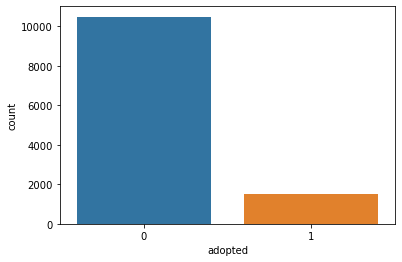

In [110]:
sns.countplot(users['adopted']);
#imbalanced data

In [120]:
# Time between users account creation and last login
delta_t = (users.last_session_creation_time - users.creation_time)
users['creation_last_session_diff'] = delta_t
users.head()
# any missing values?
#users.isnull().sum()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,invited_by_user,creation_last_session_diff
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,True,0 days
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,0,True,136 days
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,True,0 days
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,True,1 days
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,True,5 days


In [124]:
# fill missing values with mean values:
#
users['creation_last_session_diff'] = users['creation_last_session_diff'].fillna(users['creation_last_session_diff'].mean())

# convert to integer
users['creation_last_session_diff'] = pd.to_numeric(users['creation_last_session_diff'].dt.days, downcast='integer')

#users.info()

In [125]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,invited_by_user,creation_last_session_diff
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,True,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,0,True,136
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,True,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,True,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,True,5


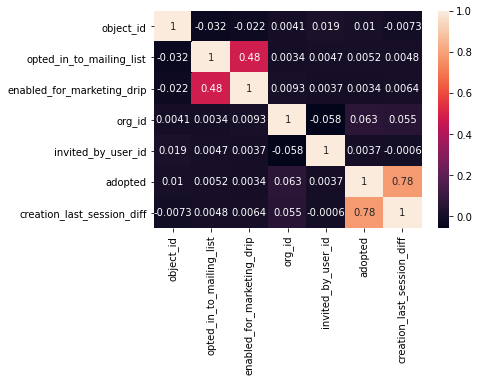

In [126]:
#Correlated features or target/feature:
sns.heatmap(users.corr(),annot=True);

No, or very weak correlation between adopted users and all the numerical columns.<br>
Linear correlation between 'opted_in_to_mailing_list' and 'enabled_for_marketing_drip'.

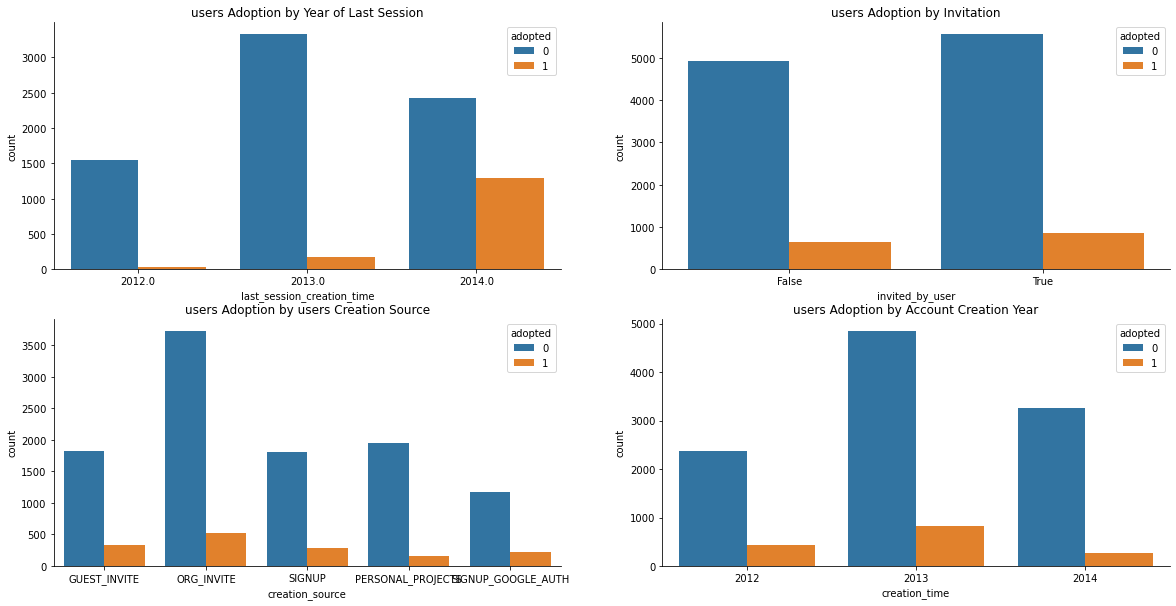

In [127]:
# look at categorical and datetime columns
plt.figure(figsize=(20,10));

ax1 = plt.subplot(2,2,1)
ax1 = sns.countplot(x=users.last_session_creation_time.dt.year, hue=users.adopted, ax=ax1)
ax1.set_title('users Adoption by Year of Last Session')

ax2 = plt.subplot(2,2,2)
ax2 = sns.countplot(x=users.invited_by_user, hue=users.adopted, ax=ax2)
ax2.set_title('users Adoption by Invitation')

ax3 = plt.subplot(2,2,3)
ax3 = sns.countplot(x='creation_source', hue='adopted', data=users, ax=ax3)
ax3.set_title('users Adoption by users Creation Source')

ax4 = plt.subplot(2,2,4)
ax4 = sns.countplot(x=users.creation_time.dt.year, hue=users.adopted, ax=ax4)
ax4.set_title('users Adoption by Account Creation Year')

sns.despine(top=True, right=True)
plt.show()

In [130]:
from collections import Counter
from sklearn.utils import resample

In [129]:
Counter(users.adopted) # count nonadopters, adopters

Counter({0: 10485, 1: 1515})

**Upscale the minority group(adopted users)**

In [131]:
# Separate majority and minority classes
users_notadopted = users[users.adopted==0]
users_adopted = users[users.adopted==1]

#df_minority = df[df.balance==1]
 
# Upsample minority class
users_adopted_upsampled = resample(users_adopted, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(users_notadopted),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([users_notadopted, users_adopted_upsampled])
 

In [210]:
# Display new class counts
df_upsampled.adopted.value_counts()

1    10485
0    10485
Name: adopted, dtype: int64

In [132]:
df_upsampled

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,invited_by_user,creation_last_session_diff
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,True,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,0,True,136
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,True,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,True,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,True,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6183,6184,2013-10-12 15:56:21,Souza Martim,ljoswivh@yxtxk.com,SIGNUP,2014-05-23 15:56:21,0,0,79,NaN,1,False,223
1480,1481,2012-07-03 15:11:46,Southerland George,GeorgeTSoutherland@cuvox.de,PERSONAL_PROJECTS,2012-10-01 15:11:46,0,0,33,NaN,1,False,90
2835,2836,2013-12-06 04:07:08,Karlsen Mathias,MathiasCKarlsen@cuvox.de,SIGNUP,2014-05-21 04:07:08,0,1,387,NaN,1,False,166
3823,3824,2012-11-09 07:00:12,Wardlaw Caitlin,jaxpedas@qcinn.com,ORG_INVITE,2014-05-22 07:00:12,1,1,161,8401.0,1,True,559


### Train model on upsampled dataset

In [184]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [133]:
users.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'adopted',
       'invited_by_user', 'creation_last_session_diff'],
      dtype='object')

In [202]:
features = df_upsampled[['creation_source', 'invited_by_user','org_id', 'opted_in_to_mailing_list',
                         'creation_last_session_diff']]

In [203]:
features_with_dummies = pd.get_dummies(features)

In [204]:
features_with_dummies.head()

,org_id,opted_in_to_mailing_list,creation_last_session_diff,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,invited_by_user_False,invited_by_user_True
0,11,1,0,1,0,0,0,0,0,1
1,1,0,136,0,1,0,0,0,0,1
2,94,0,0,0,1,0,0,0,0,1
3,1,0,1,1,0,0,0,0,0,1
4,193,0,5,1,0,0,0,0,0,1


In [205]:
y = df_upsampled.adopted   # target
X = features_with_dummies  # features

In [207]:
# Separate input features (X) and target variable (y)

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.25, random_state = 123)
 
# Train model
rf = RandomForestClassifier().fit(X_train, y_train)
 
# Predict on training set
y_pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train)
 
# How's our accuracy?
print(accuracy_score(y_test, y_pred_test))
print(accuracy_score(y_train, y_pred_train))
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

0.9862674041579248
0.999872830164685
[[2543   64]
 [   8 2628]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2607
           1       0.98      1.00      0.99      2636

    accuracy                           0.99      5243
   macro avg       0.99      0.99      0.99      5243
weighted avg       0.99      0.99      0.99      5243



#### RUN1 : 
#### Using features = 'creation_source', 'invited_by_user','org_id', 'opted_in_to_mailing_list'

In [198]:
run1_accuracy_test = print(accuracy_score(y_test, y_pred_test))
run1_accuracy_train = print(accuracy_score(y_train, y_pred_train))
run1_confusion_matrix = print(confusion_matrix(y_test, y_pred_test))
run1_classification_report = print(classification_report(y_test, y_pred_test))

0.7568186152965859
0.8206269472881033
[[1726  881]
 [ 394 2242]]
              precision    recall  f1-score   support

           0       0.81      0.66      0.73      2607
           1       0.72      0.85      0.78      2636

    accuracy                           0.76      5243
   macro avg       0.77      0.76      0.75      5243
weighted avg       0.77      0.76      0.75      5243



In [201]:

run1_feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_})
print(run1_feature_rank.sort_values(by='importance',ascending=False))

                              feature  importance
0                              org_id    0.949606
4   creation_source_PERSONAL_PROJECTS    0.022974
1            opted_in_to_mailing_list    0.009641
2        creation_source_GUEST_INVITE    0.004155
6  creation_source_SIGNUP_GOOGLE_AUTH    0.003878
3          creation_source_ORG_INVITE    0.003205
5              creation_source_SIGNUP    0.002961
7               invited_by_user_False    0.002003
8                invited_by_user_True    0.001578


#### RUN 2:
#### 'creation_source', 'invited_by_user','org_id', 'opted_in_to_mailing_list', 'creation_last_session_diff'

In [208]:
run2_accuracy_test = print(accuracy_score(y_test, y_pred_test))
run2_accuracy_train = print(accuracy_score(y_train, y_pred_train))
run2_confusion_matrix = print(confusion_matrix(y_test, y_pred_test))
run2_classification_report = print(classification_report(y_test, y_pred_test))

0.9862674041579248
0.999872830164685
[[2543   64]
 [   8 2628]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2607
           1       0.98      1.00      0.99      2636

    accuracy                           0.99      5243
   macro avg       0.99      0.99      0.99      5243
weighted avg       0.99      0.99      0.99      5243



In [209]:
run2_feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_})
print(run2_feature_rank.sort_values(by='importance',ascending=False))

                              feature  importance
2          creation_last_session_diff    0.919582
0                              org_id    0.063487
5   creation_source_PERSONAL_PROJECTS    0.007219
1            opted_in_to_mailing_list    0.002565
7  creation_source_SIGNUP_GOOGLE_AUTH    0.002214
3        creation_source_GUEST_INVITE    0.001355
6              creation_source_SIGNUP    0.001125
4          creation_source_ORG_INVITE    0.000877
8               invited_by_user_False    0.000807
9                invited_by_user_True    0.000768


In [58]:
engagement_counts.shape

(2248, 2)

### Summary

- Variable data with many different types(datetime, categorical, string, numeric), and some missing data. The EDA done here was only partial due to the time constraint, but more can be done through NLP (e.g. emails and customer names).
- Strong linear correlation between adopted users and number of days between creation and last log in.
- Strong linear correlation between those that opted into mailing list and those with enabled marketing marketing drips.
- Very high accuracy and f1 values in RUN 2. This was observed upon addition of the feature: *creation_last_session_diff* which is also the top predictor of adopted users. Possibly, because the difference between 'creation_time' and 'last_session_creation_time' could also indicate a higher number of logins in that period. This would be a good feature to engineer and look at in the next steps.

### Way Forward
- Hyper tune parameters and investigate other models.
- Further investigate the reason behind *'last_session_creation_time'* being a higher predictor of adoption.